In [ ]:
from nltk.corpus import stopwords
import json
import numpy as np
import spacy
import matplotlib.pyplot as plt

nlp = spacy.load("en_core_web_sm")
stop_words = set(stopwords.words('english'))

In [2]:
def proc_texts(texts_tup, out):
    print("Labeling!")
    for doc, meta in nlp.pipe(texts_tup, n_process=6, batch_size=1024, as_tuples=True):
        #Write metadata + lemmatized text
        meta['lemmatized'] = [t.lemma_ for t in doc]

        json.dump(meta, out)
        out.write('\n')
        
def get_meta(val, typ):
    if typ == 'post':
        return {'sentiment': val['body_sentiment'], 'type': 'post', 'id': val['id']}
    
    if typ == 'comment':
        return {'sentiment': val['text_sentiment'], 'type': 'comment', 'id': val['id']}

    return None

def lemmatize_all_text():
    doc_acc = []
    inp = open('./data/split-1.jsonl', 'r')
    outp = open('lemmatized.jsonl', 'w')

    count = 0
    for line in inp:
        count += 1
        if count % 10000 == 0: print(count)

        obj = json.loads(line)

        #Append relevant information
        doc_acc.append((obj['body'], get_meta(obj, 'post')))
        for c in obj['comments']: doc_acc.append((c['text'], get_meta(c, 'comment')))

        #Append answer data too
        for a in obj['answers']:
            doc_acc.append((a['body'], get_meta(a, 'post')))
            for c in a['comments']: doc_acc.append((c['text'], get_meta(c, 'comment')))
        
        #Process when limit reached
        if len(doc_acc) > 100000:
            proc_texts(doc_acc, outp)
            doc_acc.clear()

    #Process remaining
    if doc_acc:
        proc_texts(doc_acc, outp)
        doc_acc.clear()

    inp.close()
    outp.close()

#Run this if you need to lemmatize
#lemmatize_all_text()

In [3]:
words = {}
words_neg = {}
words_pos = {}
cnt = 0

with open('./data/lemmatized.jsonl') as inp:
    for line in inp:
        cnt += 1
        obj = json.loads(line)
        for tok in obj['lemmatized']:
            words[tok] = words.get(tok,0) + 1
            if obj['sentiment'] == 0:
                words_neg[tok] = words_neg.get(tok,0) + 1
            elif obj['sentiment'] == 2:
                words_pos[tok] = words_pos.get(tok,0) + 1
len(words)

In [4]:
idf = {k: np.log(cnt / v) for k,v in words.items()}

In [18]:
tfidf_neg = {k: v * idf[k] for k,v in words_neg.items() if v not in stop_words}
tfidf_pos = {k: v * idf[k] for k,v in words_pos.items() if v not in stop_words}


neg = sorted([(v,k) for k,v in tfidf_neg.items()], reverse=True)
pos = sorted([(v,k) for k,v in tfidf_pos.items()], reverse=True)

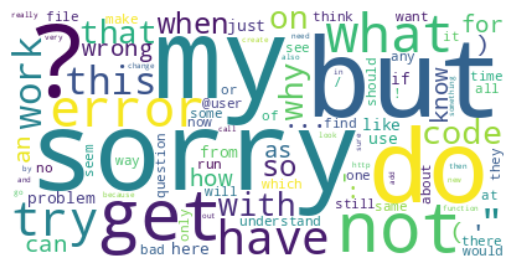

In [35]:
from wordcloud import WordCloud

wordcloud = WordCloud(background_color='white').generate_from_frequencies({w:f for f,w in neg[:100] if w != '\n'})

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig('./img/wordcloud_neg.pdf')

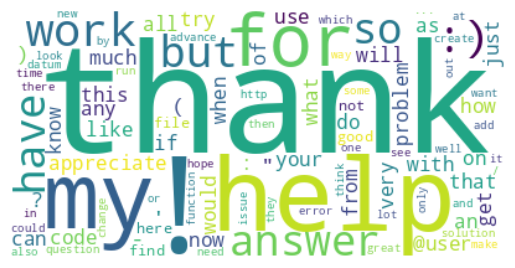

In [36]:
wordcloud = WordCloud(background_color='white').generate_from_frequencies({w:f for f,w in pos[:100] if w != '\n'})

import matplotlib.pyplot as plt
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig('./img/wordcloud_pos.pdf')

In [38]:
gram2 = {}
gram2_neg = {}
cnt = 0

with open('./data/lemmatized.jsonl') as inp:
    for line in inp:
        cnt += 1
        obj = json.loads(line)
        for i in range(1, len(obj['lemmatized'])):
            tok = obj['lemmatized'][i-1] + ' ' + obj['lemmatized'][i]
            gram2[tok] = gram2.get(tok,0) + 1
            if obj['sentiment'] == 0:
                gram2_neg[tok] = gram2_neg.get(tok,0) + 1